# Team
- **Tommaso Giordano**,
- **Guido Gonnella**,
- **Andrea Migliorini**,
- **Simone Oggioni**,
- **Luca Olivieri**.

**Video**: https://drive.google.com/file/d/1PacfOhmIsuAtYV4P8HEvrRlB0yHz85rb/view?usp=share_link

---

Due to compatibility issues with gensim library, please, after running the following cell, go to "Runtime" -> "Restart session" and run this cell again

In [ ]:
%%capture
!pip install --upgrade gensim

---

# 0.1 **Imports**

In [ ]:
!git clone https://github.com/pubmedqa/pubmedqa.git

fatal: destination path 'pubmedqa' already exists and is not an empty directory.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import re

---

# 0.2 **Data import**

**Data retrieval and cleaning**

We start by preparing every piece of text so that it’s as “clean” and comparable as possible.

First, all punctuation marks are stripped away, leaving only letters and numbers.

Then, for each question we gather every snippet of its background information, whether it’s the main contexts, specialist labels, or controlled‑vocabulary (MeSH) terms, into one long, continuous block of words. This gives us a single, uniform text representation for each example.

Finally, we apply the same punctuation‑removal step to the question itself.

By doing this, both question and context live in the same “space” of plain tokens, with no extra symbols or formatting differences.

That makes any subsequent matching or retrieval much more reliable, because we’ve eliminated sources of noise (like commas or periods) and condensed all relevant descriptive material into one place.

In [ ]:
import re
import string
import pandas as pd

def clean_text(
    text,
    remove_unicode=True,
    remove_punctuation=True,
    remove_digits=True,
    normalize_whitespace=True
):
    if not isinstance(text, str):
        return ""

    if remove_unicode:
        text = text.encode('ascii', 'ignore').decode()

    if remove_punctuation and remove_digits:
        pattern = string.punctuation + string.digits
        text = re.sub(r'[' + re.escape(pattern) + ']', '', text)
    elif remove_punctuation:
        text = re.sub(r'[' + re.escape(string.punctuation) + ']', '', text)
    elif remove_digits:
        text = re.sub(r'\d+', '', text)

    if normalize_whitespace:
        text = re.sub(r'\s+', ' ', text)

    return text.strip()

def merge_context(row, include_labels=False, include_meshes=False, remove_unicode=True, remove_punctuation=True, remove_digits=True, normalize_whitespace=True):
    s = ' '.join(row['context']['contexts'])
    if include_labels:
        s += ' ' + ' '.join(row['context'].get('labels', []))
    if include_meshes:
        s += ' ' + ' '.join(row['context'].get('meshes', []))
    s = clean_text(s, remove_unicode, remove_punctuation, remove_digits, normalize_whitespace)
    return s

def process_dataframe(df, include_labels=False, include_meshes=True, remove_unicode=True, remove_punctuation=True, remove_digits=True, normalize_whitespace=True):
    df['context'] = df.apply(lambda row: merge_context(row, include_labels, include_meshes, remove_unicode, remove_punctuation, remove_digits, normalize_whitespace), axis=1)

    for col in ['question', 'long_answer']:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: clean_text(x, remove_unicode, remove_punctuation, remove_digits, normalize_whitespace))

    return df

def download_and_process_dataframes(remove_unicode=True, remove_punctuation=True, remove_digits=True, normalize_whitespace=True, include_labels=False, include_meshes=True):
    # Load datasets
    artificial = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet").sort_values(by='pubid')
    labeled = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_labeled/train-00000-of-00001.parquet").sort_values(by='pubid')
    unlabeled = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_unlabeled/train-00000-of-00001.parquet").sort_values(by='pubid')

    # Apply processing with the provided filters
    artificial = process_dataframe(artificial, include_labels, include_meshes, remove_unicode, remove_punctuation, remove_digits, normalize_whitespace)
    labeled = process_dataframe(labeled, include_labels, include_meshes, remove_unicode, remove_punctuation, remove_digits, normalize_whitespace)
    unlabeled = process_dataframe(unlabeled, include_labels, include_meshes, remove_unicode, remove_punctuation, remove_digits, normalize_whitespace)

    return artificial, labeled, unlabeled

In [ ]:
df_a, df_l, df_u = download_and_process_dataframes()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


---

# 1.0 **Document indexing and searching**

We install pyterrier for the information retrieval phase and initialize it

In [ ]:
%%capture
!pip install -q python-terrier==0.11.0

In [ ]:
import pyterrier as pt

if not pt.started():
    pt.init()

<ipython-input-7-723b7dd8a6cc>:3: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-7-723b7dd8a6cc>:4: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


The idea here is to build a “vocabulary” and an optimized search structure that can quickly answer any query based on the long‑answer texts.

First, each example (i.e. each potential long answer) is converted into a uniquely numbered document. Those documents are then organized into an inverted index: a mapping that, for every vocabulary term, lists all the documents in which that term appears. In other words, it flips the relationship from “document → words” to “word → documents.”

In [ ]:
def build_pt_corpus(df, prefix, text):
    return [
        {"docno": f"{prefix}{i}", "text": row[text]}
        for i, row in df.iterrows()
    ]

long_answer_corpus = build_pt_corpus(df_l, "L", "long_answer")

In [ ]:
def create_index(corpus):
    index_path = "./pt_index_pubmedqa_labeled"
    indexer = pt.IterDictIndexer(index_path, overwrite=True, meta=['docno','text'], meta_reverse=['docno'])
    index_ref = indexer.index(corpus)
    index = pt.IndexFactory.of(index_ref)

    return index
index = create_index(long_answer_corpus)

Once the index is built, the system computes a few global collection statistics:
- There are 1000 “documents” in the index. Here each document corresponds to one row of df_l, i.e. 1000 indexed contexts.
- The number of unique terms (word) found in all documents after tokenization and punctuation removal is 14936.
- The total number of postings in the inverted index is 92198: each posting is a pairing (term, document) indicating “term T appears in document D.” It is the sum of the document-term frequencies
-The total occurrences of all words in all documents (sum of the lengths in tokens of each document) is 146253.

In [ ]:
print(index.getCollectionStatistics().toString())

Number of documents: 1000
Number of terms: 4713
Number of postings: 19766
Number of fields: 1
Number of tokens: 22876
Field names: [text]
Positions:   false



**Find long answer from question**

The loop iterates over the first 1,000 labeled questions and submits each one to two retrieval models: TF‑IDF and BM25.

Each model returns a ranked list of documents ordered by relevance to the query. We take the top‑1 result (the highest‑scoring document) and check whether its document ID matches the ID of the original document from which the question was drawn. If it does, we increment a success counter.

At the end, dividing the number of successes by 1,000 yields the proportion of times each method placed the correct document in first position, i.e. the hit@1, or “accuracy,” for this retrieval experiment.

In [ ]:
tf_correct = 0
bm_correct = 0
tf_idf = pt.terrier.Retriever(index, wmodel="TF_IDF")
bm25 = pt.terrier.Retriever(index, wmodel="BM25")

for document in range(1000):
    query = df_l.iloc[document]['question']

    tfidf_result = tf_idf.search(query)
    # Check if tfidf_result is empty before accessing it
    if not tfidf_result.empty:
        tfid_id = tfidf_result.iloc[0]['docid']
        if(tfid_id == document):
            tf_correct += 1
    else:
        print(f"No results found for doc (TF-IDF): {document}")  # Print a message if no results are found

    bm25_result = bm25.search(query)
    # Check if bm25_result is empty before accessing it
    if not bm25_result.empty:
        bm25_id = bm25_result.iloc[0]['docid']
        if(bm25_id == document):
            bm_correct += 1  # Increment bm_correct if bm25 search is correct
    else:
        print(f"No results found for doc (BM25): {document}")  # Print a message if no results are found

print(f'TF-IDF accuracy: {tf_correct/1000:.2f}')
print(f'bm25 accuracy: {bm_correct/1000:.2f}')

No results found for doc (TF-IDF): 378
No results found for doc (BM25): 378
No results found for doc (TF-IDF): 748
No results found for doc (BM25): 748
TF-IDF accuracy: 0.79
bm25 accuracy: 0.80


**Given a query find the most similar question**

Whenever a new query arrives, the system treats the existing question‑answer pairs as a searchable knowledge base.

It computes a relevance score between the incoming text and every stored question, then selects the single stored question that best matches.

Finally, it returns the expert‑written answer that goes with that top match.

In [ ]:
def find_most_similar_question(query, index, df):
    tf_idf = pt.terrier.Retriever(index, wmodel="TF_IDF")
    result = tf_idf.search(query)
    return df.iloc[result.iloc[0]['docid']]

query = 'general practitioner hospitals beds utilisation'
question_corpus = build_pt_corpus(df_l, "L", "long_answer")
question_index = create_index(question_corpus)
result = find_most_similar_question(query=query, index=question_index, df=df_l)

print(f'Query: {query}\n')
print(f'Most similar question: {result["question"]}\n')
print(f'Long answer: {result["long_answer"]}')

Query: general practitioner hospitals beds utilisation

Most similar question: Do general practitioner hospitals reduce the utilisation of general hospital beds

Long answer: GP hospitals seem to reduce the utilisation of general hospitals with respect to admissions as well as occupied bed days


---

# 2.0 **Semantic Retrieval using SentenceTransformer**

hnswlib is a fast C++ library (with Python bindings) for approximate nearest‑neighbor search using a hierarchical small‑world graph. It lets us retrieve the top candidate embeddings in sub‑linear time.

We use a bi‑encoder (multi‑qa‑MiniLM‑L6‑cos‑v1) to cheaply embed questions and passages into the same vector space for fast retrieval, and a cross‑encoder (ms‑marco‑MiniLM‑L-6‑v2) to re‑score those top candidates with full token‑level attention for higher accuracy.

In [ ]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp311-cp311-linux_x86_64.whl size=2389209 sha256=19b909b1ee56f399be95069280ddb3cf2729c7abb5cd26942383d45b3a27c7da
  Stored in directory: /root/.cache/pip/wheels/ea/4e/27/39aebca9958719776e36fada290845a7ef10f053ad70e22ceb
Successfully built hnswlib


In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import pandas as pd
import hnswlib
from tqdm import tqdm
import os

In [ ]:
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

This block of code sets up the corpus for retrieval. It extracts the "long_answer" column and encodes each entry into dense vector representations using a bi-encoder model.

These embeddings are then indexed using HNSW (Hierarchical Navigable Small World), a graph-based structure optimized for fast approximate nearest neighbor search based on cosine similarity.

If an index file already exists, it is loaded from disk; otherwise, a new one is created and saved. This enables efficient retrieval of the most semantically similar passages given a query.

In [ ]:
df_corpus = df_l
df_q = df_l

corpus_texts = df_corpus["long_answer"].tolist()
corpus_ids = list(range(len(corpus_texts)))

print("Step 1: Encoding corpus with bi‑encoder…")
corpus_embeddings = bi_encoder.encode(corpus_texts, convert_to_tensor=False, show_progress_bar=True)

Step 1: Encoding corpus with bi‑encoder…


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
dim = len(corpus_embeddings[0])
index = hnswlib.Index(space='cosine', dim=dim)
index_path = "pubmedqa_hnsw_index.bin"

if os.path.exists(index_path):
    print("Loading existing HNSW index from disk…")
    index.load_index(index_path)
    print("Done!")
else:
    print("Creating new HNSW index and adding items…")
    index.init_index(max_elements=len(corpus_embeddings), ef_construction=400, M=64)
    index.add_items(corpus_embeddings, corpus_ids)
    index.save_index(index_path)
    print(f"HNSW index saved to '{index_path}'.")

Loading existing HNSW index from disk…
Done!


**Evaluation of the retrieval pipeline with re-ranking**

For each question in the dataset, it first retrieves the top‑k most similar candidate answers using the bi-encoder and HNSW index. It checks whether the correct answer appears at the top (top‑1) or within the top‑k retrieved items.

Then, it applies a cross-encoder to re-rank these top‑k candidates by computing a more precise relevance score for each question-answer pair. The best-scoring answer is selected and compared to the ground truth.

Finally, it computes and prints the top‑1 and top‑k accuracy of the bi-encoder, along with the accuracy after cross-encoder re-ranking, allowing a direct comparison of performance improvements.

In [ ]:
top_k = 5
correct_bi_1 = 0   # top‑1 bi‑encoder
correct_bi_k = 0   # top‑k bi‑encoder
correct_rerank = 0
total = len(df_q)

for i, row in tqdm(df_q.iterrows(), total=total):
    query = row["question"]
    true_answer = row["long_answer"].strip()

    # (a) Bi‑encoder retrieval over top_k
    q_emb = bi_encoder.encode(query, convert_to_tensor=False)
    candidate_ids, distances = index.knn_query(q_emb, k=top_k)
    hits = [contexts[idx].strip() for idx in candidate_ids[0]]

    if hits[0] == true_answer: # top‑1
        correct_bi_1 += 1

    if true_answer in hits: # top‑k
        correct_bi_k += 1

    # (b) Cross‑encoder re‑ranking over top_k
    pairs = [(query, hits[j]) for j in range(top_k)]
    cross_scores = cross_encoder.predict(pairs)
    best = hits[cross_scores.argmax()]
    if best == true_answer:
        correct_rerank += 1

acc_bi_1 = correct_bi_1 / total
acc_bi_k = correct_bi_k / total
acc_rerank = correct_rerank / total

print("\n=== Evaluation Results ===")
print(f"Bi‑encoder top‑1 accuracy (@1): {acc_bi_1:.4f}")
print(f"Bi‑encoder top-{top_k} accuracy: {acc_bi_k:.4f}")
print(f"After cross‑encoder re‑ranking of top-{top_k}, top-1 accuracy (@1): {acc_rerank:.4f}")


100%|██████████| 1000/1000 [00:17<00:00, 57.03it/s]


=== Evaluation Results ===
Bi‑encoder top‑1 accuracy (@1): 0.7560
Bi‑encoder top‑5 accuracy: 0.8590
After cross‑encoder re‑ranking of top-5, top-1 accuracy (@1): 0.8270


**Semantic search with re-ranking**

First, it uses a bi-encoder to encode the input query and retrieve the top-k most similar candidate documents from a pre-indexed corpus based on vector similarity. Then, it applies a cross-encoder to re-rank these candidates by scoring each (query, document) pair more precisely.

The raw similarity scores from the cross-encoder are normalized using the sigmoid function (expit) to transform them into probabilities, making them easier to interpret. Finally, the top-ranked results are printed along with their normalized relevance scores.

In [ ]:
from scipy.special import expit

def semantic_search_with_rerank(query: str, top_k_bi: int = 128, top_k_cross: int = 3):
    print(f"\nQuery: \"{query}\"\n{'-'*80}")

    query_embedding = bi_encoder.encode(query, convert_to_tensor=True)

    corpus_ids, _ = index.knn_query(query_embedding.cpu(), k=top_k_bi)
    top_candidates = corpus_ids[0]

    model_inputs = [(query, passages[idx]) for idx in top_candidates]
    cross_scores = cross_encoder.predict(model_inputs)
    cross_scores_probabilities = expit(cross_scores)

    best_idxs = np.argsort(-cross_scores)[:top_k_cross]
    for rank, idx in enumerate(best_idxs, 1):
        doc_idx = top_candidates[idx]
        print(f"Rank #{rank} | Score: {cross_scores_probabilities[idx]:.4f}")
        print(f"Question: {df_l.iloc[doc_idx]['question']}")
        print(f"Answer: {df_l.iloc[doc_idx]['long_answer']}\n")

passages = df_l["question"].tolist()
query = "general practitioner hospitals beds utilisation"
semantic_search_with_rerank(query)


Query: "general practitioner hospitals beds utilisation"
--------------------------------------------------------------------------------
Rank #1 | Score: 0.9993
Question: Do general practitioner hospitals reduce the utilisation of general hospital beds
Answer: GP hospitals seem to reduce the utilisation of general hospitals with respect to admissions as well as occupied bed days

Rank #2 | Score: 0.0005
Question: A short stay or hour ward in a general and academic childrens hospital are they effective
Answer: This data demonstrates the robust nature of the short stay ward At these two very different institutions we have shown improved bed efficient and patient care in a costeffective way We have also reported on greater parental satisfaction and early return of the child with their family to the community

Rank #3 | Score: 0.0004
Question: Should general practitioners call patients by their first names
Answer: General practitioners should consider using patients first names more ofte

---

# 3.0 **Word2Vec**

In [ ]:
from pandas.core.common import flatten

df_a, df_l, df_u = download_and_process_dataframes(remove_punctuation=False)
sentences = df_a[['question', 'context', 'long_answer']].values.tolist()
sentences = list(flatten(sentences))
sentences = list(flatten([re.split('[?!.]\s', doc) for doc in sentences]))
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['does', 'thyrotropin', 'releasing', 'hormone', 'increase', 'the', 'amount', 'of', 'surfactant', 'in', 'lung', 'lavage', 'from', 'fetal', 'rabbits']
['administration', 'of', 'thyrotropin', 'releasing', 'hormone', 'trh', 'to', 'pregnant', 'rabbits', 'at', 'and', 'days', 'of', 'gestation', 'results', 'in', 'increased', 'pulmonary', 'surfactant', 'production', 'by', 'the', 'fetus', 'at', 'days', 'full', 'term', 'is', 'days']
['there', 'was', 'more', 'total', 'phospholipid', 'and', 'more', 'phosphatidylcholine', 'the', 'major', 'component', 'of', 'surfactant', 'in', 'the', 'lung', 'lavage', 'from', 'the', 'fetuses', 'in', 'the', 'treated', 'group', 'than', 'in', 'that', 'from', 'the', 'controls']
['lung', 'lavage', 'from', 'the', 'fetuses', 'in', 'the', 'treated', 'litters', 'contained']
['micrograms', 'of', 'total', 'phospholipid', 'phosphorus', 'g', 'lung', 'dry', 'wt', 'and']
['micrograms', 'of', 'phosphatidylcholine', 'phosphorus', 'while', 'that', 'from', 'the', 'fetuses', 'in', 'the'

In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=40)

In [ ]:
def get_similar_words(model, terms, top_n=10, show_scores=True):
    # Convert single term to list for consistent processing
    if isinstance(terms, str):
        terms = [terms]

    # Process each term
    for term in terms:
        try:
            # Check if term exists in vocabulary
            if term not in model.wv.key_to_index:
                print(f"\n{'-'*60}")
                print(f"'{term}' not found in vocabulary.")
                continue

            # Get similar words
            similar_words = model.wv.most_similar(term, topn=top_n)

            # Format and print results
            print(f"\n{'-'*60}")
            print(f"Words similar to '{term}':")
            print(f"{'-'*60}")

            # Calculate column width for alignment
            max_word_len = max(len(word) for word, _ in similar_words)

            # Print header
            if show_scores:
                print(f"{'Term':{max_word_len+2}}  {'Similarity'}")
                print(f"{'-'*(max_word_len+2)}  {'-'*10}")
            else:
                print(f"{'Term':{max_word_len+2}}")
                print(f"{'-'*(max_word_len+2)}")

            # Print each similar word
            for word, similarity in similar_words:
                if show_scores:
                    print(f"{word:{max_word_len+2}}  {similarity:.4f}")
                else:
                    print(f"{word:{max_word_len+2}}")

        except Exception as e:
            print(f"Error processing term '{term}': {str(e)}")

The following function uses `most_similar()` from the `gensim` library that utilizes the cosine similarity function:
$$
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \, \|\mathbf{B}\|}
$$
it measures the similiratiy between all other vectors and returns the top-n scoring keys and their score


In [ ]:
def get_similar_words_by_vect(model, vect, top_n=10, show_scores=True):
        try:
            # Get similar words with a vector instead
            similar_words = model.wv.similar_by_vector(vec, topn=top_n)
            # Format and print results
            print(f"{'-'*60}")

            # Calculate column width for alignment
            max_word_len = max(len(word) for word, _ in similar_words)

            # Print header
            if show_scores:
                print(f"{'Term':{max_word_len+2}}  {'Similarity'}")
                print(f"{'-'*(max_word_len+2)}  {'-'*10}")
            else:
                print(f"{'Term':{max_word_len+2}}")
                print(f"{'-'*(max_word_len+2)}")

            # Print each similar word
            for word, similarity in similar_words:
                if show_scores:
                    print(f"{word:{max_word_len+2}}  {similarity:.4f}")
                else:
                    print(f"{word:{max_word_len+2}}")

        except Exception as e:
            print(f"Error processing term '{vect}': {str(e)}")

In [ ]:
def get_analogy(model, positive, negative, top_n=10, show_scores=True):
        try:
            # Get similar words with a vector instead
            similar_words = model.wv.most_similar(positive=positive,negative=negative,topn=top_n)
            # Format and print results
            print(f"\n{'-'*60}")
            print(f"Words similar to '{positive[0]}'+ '{positive[1]}'-'{negative[0]}':")
            print(f"{'-'*60}")
            # Calculate column width for alignment
            max_word_len = max(len(word) for word, _ in similar_words)

            # Print header
            if show_scores:
                print(f"{'Term':{max_word_len+2}}  {'Similarity'}")
                print(f"{'-'*(max_word_len+2)}  {'-'*10}")
            else:
                print(f"{'Term':{max_word_len+2}}")
                print(f"{'-'*(max_word_len+2)}")

            # Print each similar word
            for word, similarity in similar_words:
                if show_scores:
                    print(f"{word:{max_word_len+2}}  {similarity:.4f}")
                else:
                    print(f"{word:{max_word_len+2}}")

        except Exception as e:
            print(f"Error processing term '{vect}': {str(e)}")

This method tries to find analogies to the words by computing the mean of the vectors associated to the keys and then applies the previously mentioned cosine similarity over this mean and the rest of the embeddings, returning the highest top-n similarity scores.

Let's start analyzing the embeddings by seeing if we can find any similar words to more general concepts present in the vocabulary

In [ ]:
terms = ['cancer', 'virus', 'treatment','department','neurosurgery']
get_similar_words(model, terms, top_n=4)


------------------------------------------------------------
Words similar to 'cancer':
------------------------------------------------------------
Term              Similarity
----------------  ----------
carcinoma         0.9014
adenocarcinoma    0.8954
cancers           0.8891
carcinomas        0.8648

------------------------------------------------------------
Words similar to 'virus':
------------------------------------------------------------
Term           Similarity
-------------  ----------
viral          0.8409
kshv           0.8406
rabv           0.8362
enterovirus    0.8347

------------------------------------------------------------
Words similar to 'treatment':
------------------------------------------------------------
Term                 Similarity
-------------------  ----------
therapy              0.8604
thalidomide          0.7814
chemoradiotherapy    0.7403
chemotherapy         0.7283

------------------------------------------------------------
Words simila

As we can see, the embeddings captured at least part of the original significance of the training text.
"treatment" and "cancer" paired with synonyms or other more technical terms.
Even more specific terms like "neurosurgery" got paired well with terms related to its discipline.
Let's see if we can identify more general categories by using the mean vector.

In [ ]:
terms = ['herpesvirus','sars','ebolavirus','hepatitis']
get_similar_words_by_vect(model,model.wv.get_mean_vector(terms),top_n=5)

------------------------------------------------------------
Term                  Similarity
--------------------  ----------
klebsiella            0.9548
streptococcus         0.9347
enterobacteriaceae    0.9280
haemophilus           0.9266
influenzae            0.9259


Unfortunately, that does not seem to be the case so we find  mostly other bacteria.

In [ ]:
terms = ["herpesvirus","sars"]
get_similar_words(model, terms, top_n=5)


------------------------------------------------------------
Words similar to 'herpesvirus':
------------------------------------------------------------
Term               Similarity
-----------------  ----------
herpes             0.8319
cytomegalovirus    0.8113
barr               0.8102
kaposi             0.8094
virus              0.8077

------------------------------------------------------------
Words similar to 'sars':
------------------------------------------------------------
Term           Similarity
-------------  ----------
coronavirus    0.9374
cov            0.8740
dengue         0.8542
coxiella       0.8535
borrelia       0.8463


As we can see, what we get is other types of herpes viruses from the first term. While from "sars" we get some infectious viruses and we do not mantain that relatively strict similarity, "coxiella" and "borrelia" are actually bacteria. So the embedding due to the variety of the training set is clearly influencing the quality of the embeddings.

Let's try to see if we are able to get the very common analogy of "king" + ("woman" - "man") = "queen".

In [ ]:
get_analogy(model, positive=['king','woman'], negative=['man'], top_n=5)


------------------------------------------------------------
Words similar to 'king'+ 'woman'-'man':
------------------------------------------------------------
Term        Similarity
----------  ----------
midwife     0.8029
county      0.7656
detroit     0.7571
portugal    0.7488
counties    0.7443


As expected the analogy does not work, after all this embedding is trained on a dataset of medical studies, so it does not have the same general knowledge as models trained on larger datasets.

Let's if we can find any anologies with terms actually related to medicine.
We can start from the relation between departments and their specific doctors.

In [ ]:
terms = ['pathology','pathologist','oncology','oncologist']
get_similar_words(model, terms, top_n=4)
get_analogy(model, positive=['pathology','neurologists'], negative=['neurology'], top_n=4)
get_analogy(model, positive=['oncology','neurologists'], negative=['neurology'], top_n=4)


------------------------------------------------------------
Words similar to 'pathology':
------------------------------------------------------------
Term           Similarity
-------------  ----------
pathologies    0.7945
lesions        0.7832
atrophy        0.7514
hamartomas     0.7443

------------------------------------------------------------
Words similar to 'pathologist':
------------------------------------------------------------
Term            Similarity
--------------  ----------
pathologists    0.8650
radiologist     0.7914
slides          0.7567
perirectal      0.7436

------------------------------------------------------------
Words similar to 'oncology':
------------------------------------------------------------
Term           Similarity
-------------  ----------
rtog           0.8283
cooperative    0.7757
sloan          0.7755
mskcc          0.7674

------------------------------------------------------------
Words similar to 'oncologist':
---------------------

In [ ]:
terms = ['neurology','neurologist','dermatology','radiology']
get_similar_words(model, terms, top_n=4)

get_analogy(model, positive=['dermatology','neurologists'], negative=['neurology'], top_n=4)
get_analogy(model, positive=['radiology','neurologists'], negative=['neurology'], top_n=4)


------------------------------------------------------------
Words similar to 'neurology':
------------------------------------------------------------
Term            Similarity
--------------  ----------
departments     0.8820
service         0.8554
toronto         0.8491
neurologists    0.8386

------------------------------------------------------------
Words similar to 'neurologist':
------------------------------------------------------------
Term              Similarity
----------------  ----------
neurologists      0.8739
neurology         0.8014
rheumatologist    0.7974
mpds              0.7798

------------------------------------------------------------
Words similar to 'dermatology':
------------------------------------------------------------
Term                Similarity
------------------  ----------
gastroenterology    0.8131
dermatologist       0.8035
specialist          0.7857
kuala               0.7845

------------------------------------------------------------
W

As we can see, only by starting with words already similar to each other, such as dermatology and dermatoligist, that already reference eachother, the analogy  it only improves the similarity score with radiology

Let's try then to see if the word embedding was able to capture concepts like illness-treatment.
Starting from more generic illnesses from viruses.

In [ ]:
get_analogy(model, positive=['influenza','antiviral'], negative=['virus'], top_n=5)

get_analogy(model, positive=['influenza','cidofovir'], negative=['herpesvirus'], top_n=5)

------------------------------------------------------------
Term           Similarity
-------------  ----------
vaccination    0.7516
hcv            0.7428
virologic      0.7425
virological    0.7344
nonresponse    0.7312
------------------------------------------------------------
Term            Similarity
--------------  ----------
opv             0.8506
oseltamivir     0.8189
isoniazid       0.8188
moxifloxacin    0.8079
booster         0.8005


The first anology did not really work, only extracting strategies to prevent influenza. The second one does seem to work probably thanks to a specific antiviral-virus vector, but influenza might have too many variations and in the end it only extracts terms vaguely related to treatment: only "oseltamivir" is actually an antiviral drug.

Let's try with more specific viruses.

In [ ]:
terms = ['herpesvirus','cidofovir','ribavirin', 'hepatitis','sars']
get_similar_words(model, terms, top_n=5)


------------------------------------------------------------
Words similar to 'herpesvirus':
------------------------------------------------------------
Term               Similarity
-----------------  ----------
herpes             0.8319
cytomegalovirus    0.8113
barr               0.8102
kaposi             0.8094
virus              0.8077

------------------------------------------------------------
Words similar to 'cidofovir':
------------------------------------------------------------
Term                Similarity
------------------  ----------
ganciclovir         0.8819
acyclovir           0.8385
antituberculosis    0.8072
virotherapy         0.8060
pmpa                0.8056

------------------------------------------------------------
Words similar to 'ribavirin':
------------------------------------------------------------
Term             Similarity
---------------  ----------
peginterferon    0.9315
rbv              0.8819
pegylated        0.8578
pegifn           0.8440


In [ ]:
get_analogy(model, positive=['ribavirin','herpesvirus'], negative=['cidofovir'], top_n=5)
get_analogy(model, positive=['hepatitis','cidofovir'], negative=['herpesvirus'], top_n=5)

------------------------------------------------------------
Term          Similarity
------------  ----------
myeloid       0.7419
interferon    0.7326
barr          0.7135
xenotropic    0.7123
caml          0.7020
------------------------------------------------------------
Term             Similarity
---------------  ----------
peginterferon    0.8501
pegifn           0.8146
entecavir        0.8096
telaprevir       0.8078
ribavirin        0.7982


Starting from the treatment the relation does not yield any results but in the other direction it does seem to at least mantain the original similitude and the similarity to the more common remedies has actually improved.

In [ ]:
get_analogy(model, positive=['herpesvirus','ribavirin'], negative=['hepatitis'], top_n=5)
get_analogy(model, positive=['hiv','ribavirin'], negative=['hepatitis'], top_n=5)

------------------------------------------------------------
Term         Similarity
-----------  ----------
herpes       0.8220
hsv          0.7876
genitalis    0.7826
simplex      0.7517
zoster       0.7371
------------------------------------------------------------
Term              Similarity
----------------  ----------
prep              0.8697
art               0.8230
nnrtis            0.8145
antiretroviral    0.8145
nonnucleoside     0.8139


Unfortunately the same can not be said for other viruses so this relation is once again not generalizable.

Bactieria might offer a better ground for this type of the relation because of the genera involved in any infection description.

In [ ]:
terms=['folliculitis','pneumonia','staphylococcus','streptococcus']
get_similar_words(model, terms, top_n=4)

get_analogy(model, positive=['folliculitis','isoniazid'], negative=['meningitis'], top_n=5)
get_analogy(model, positive=['pneumonia','isoniazid'], negative=['meningitis'], top_n=5)

get_analogy(model, positive=['staphylococcus','antibiotic'], negative=['bacteria'], top_n=5)

get_analogy(model, positive=['staphylococcus','isoniazid'], negative=['meningitis'], top_n=5)
get_analogy(model, positive=['streptococcus','isoniazid'], negative=['meningitis'], top_n=5)


------------------------------------------------------------
Words similar to 'folliculitis':
------------------------------------------------------------
Term           Similarity
-------------  ----------
aphthous       0.8432
keloidalis     0.7921
gangrenosum    0.7812
pustules       0.7775

------------------------------------------------------------
Words similar to 'pneumonia':
------------------------------------------------------------
Term           Similarity
-------------  ----------
bacteremia     0.8773
bacteraemia    0.8616
melioidosis    0.8425
nosocomial     0.8278

------------------------------------------------------------
Words similar to 'staphylococcus':
------------------------------------------------------------
Term              Similarity
----------------  ----------
aureus            0.8913
staphylococcal    0.8891
klebsiella        0.8671
epidermidis       0.8257

------------------------------------------------------------
Words similar to 'streptococcus':

So it does, it is even able to identify treatment to illnesses caused by bacterial infection: while not the most common it is still supposedly suggesting at least partly effective antibiotics..

it is not effective with more generic terms as the vectors but it works well especially with specific bacteria genera, offering commonly used antibiotics against them.

Let's try and see if it was actually able to catch the general categories involved.

In [ ]:
terms = ['oxacillin','penicillin','isoniazid', 'methicillin']
vec=model.wv.get_mean_vector(terms)
get_similar_words_by_vect(model,vec,top_n=10)
terms = ['staphylococcus','streptococcus','klebsiella', 'enterobacteriaceae']
vec=model.wv.get_mean_vector(terms)
get_similar_words_by_vect(model,vec,top_n=10)

------------------------------------------------------------
Term                Similarity
------------------  ----------
fluoroquinolones    0.9361
imipenem            0.9278
ceftazidime         0.9262
quinolone           0.9237
fluconazole         0.9169
penicillin          0.9140
trimethoprim        0.9116
colistin            0.9097
ampicillin          0.9069
amoxicillin         0.9053
------------------------------------------------------------
Term                  Similarity
--------------------  ----------
klebsiella            0.9548
streptococcus         0.9347
enterobacteriaceae    0.9280
haemophilus           0.9266
influenzae            0.9259
staphylococcus        0.9176
aureus                0.9176
acinetobacter         0.8983
enterococcus          0.8901
candida               0.8891


So in the end the embedding related to bacterias ends up being much more consistent compared to viruses, it groups antibiotics and bacteria in their respective categories.

Following these results we can only conclude that while some specific relations were captured by the embeddings, the dataset was too varied and too small to have any complete generalization capabilities.

---

# 4.0 **Context retrieval**

In the real world we may not always have the context, so in this section we are going to see some techniques to deal with this case.

We will use the retrieve and re-rank approach: do a first search with a bi-encoder model and then perform the final ranking with a cross-encoder

## Create index

In [ ]:
%%capture
!pip install hnswlib

In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import pandas as pd
import hnswlib
from tqdm import tqdm
import os

In [ ]:
df_a, df_l, df_u = download_and_process_dataframes()

In [ ]:
%%capture
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

We iterate over the dataset queries, predict the contexts, and compute the accuracy of context retrieval

In [ ]:
dataframe = df_l

# Compute context embeddings
contexts_emb = dataframe["context"].tolist()
ids = list(range(len(contexts_emb)))

print("Step 1: Encoding corpus with bi‑encoder…")
corpus_embeddings = bi_encoder.encode(contexts_emb, convert_to_tensor=False, show_progress_bar=True)

Step 1: Encoding corpus with bi‑encoder…


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Create index for fast embeddings retrieval
dim = corpus_embeddings.shape[1]
index = hnswlib.Index(space='cosine', dim=dim)
index_path = "pubmedqa_hnsw_contexts_index.bin"

if os.path.exists(index_path):
    print("Loading existing HNSW index from disk…")
    index.load_index(index_path)
    print("Done!")
else:
    print("Creating new HNSW index and adding items…")
    index.init_index(max_elements=len(corpus_embeddings), ef_construction=400, M=64)
    index.add_items(corpus_embeddings, ids)
    index.save_index(index_path)
    print(f"HNSW index saved to '{index_path}'.")

Loading existing HNSW index from disk…
Done!


## Calculate retrieval results

In [ ]:
top_k_values = [2,3,5,10]
stats = {
    k: {
        "correct_bi_1": 0,
        "correct_bi_k": 0,
        "correct_rerank": 0
    } for k in top_k_values
}

total = len(dataframe)

for i, row in tqdm(dataframe.iterrows(), total=total):
    query = row["question"]
    true_answer = row["context"].strip()
    query_emb = bi_encoder.encode(query, convert_to_tensor=False)

    for top_k in top_k_values:
        candidate_ids, distances = index.knn_query(query_emb, k=top_k)
        hits = [contexts_emb[idx].strip() for idx in candidate_ids[0]]

        if hits[0] == true_answer:
            stats[top_k]["correct_bi_1"] += 1
        if true_answer in hits:
            stats[top_k]["correct_bi_k"] += 1

        # Cross-encoder re-ranking
        pairs = [(query, hits[j]) for j in range(top_k)]
        cross_scores = cross_encoder.predict(pairs)
        best = hits[cross_scores.argmax()]
        if best == true_answer:
            stats[top_k]["correct_rerank"] += 1

# Print results
print("\n=== Evaluation Results ===")
for top_k in top_k_values:
    acc_bi_1 = stats[top_k]["correct_bi_1"] / total
    acc_bi_k = stats[top_k]["correct_bi_k"] / total
    acc_rerank = stats[top_k]["correct_rerank"] / total
    print(f"\nTop-{top_k} stats:")
    print(f"Bi‑encoder top‑1 accuracy (@1): {acc_bi_1:.4f}")
    print(f"Bi‑encoder top‑{top_k} accuracy: {acc_bi_k:.4f}")
    print(f"Cross‑encoder re‑ranking top-1 accuracy: {acc_rerank:.4f}")


100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


=== Evaluation Results ===

Top-2 stats:
Bi‑encoder top‑1 accuracy (@1): 0.9030
Bi‑encoder top‑2 accuracy: 0.9310
Cross‑encoder re‑ranking top-1 accuracy: 0.9270

Top-3 stats:
Bi‑encoder top‑1 accuracy (@1): 0.9030
Bi‑encoder top‑3 accuracy: 0.9430
Cross‑encoder re‑ranking top-1 accuracy: 0.9380

Top-5 stats:
Bi‑encoder top‑1 accuracy (@1): 0.9030
Bi‑encoder top‑5 accuracy: 0.9510
Cross‑encoder re‑ranking top-1 accuracy: 0.9460

Top-10 stats:
Bi‑encoder top‑1 accuracy (@1): 0.9030
Bi‑encoder top‑10 accuracy: 0.9580
Cross‑encoder re‑ranking top-1 accuracy: 0.9500


Plot results:

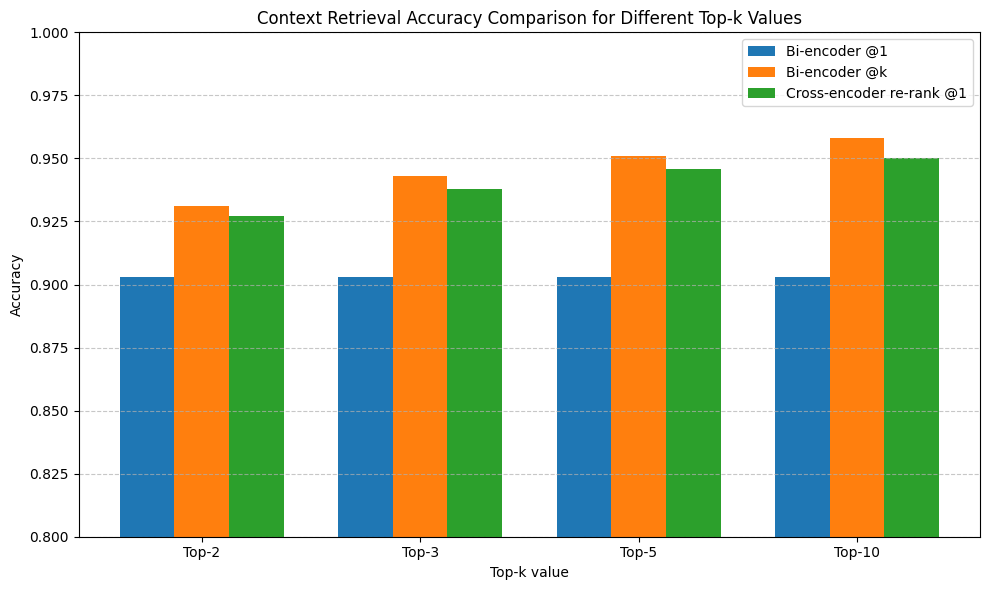

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
top_k_values = sorted(stats.keys())
bi_1_accuracies = [stats[k]["correct_bi_1"] / total for k in top_k_values]
bi_k_accuracies = [stats[k]["correct_bi_k"] / total for k in top_k_values]
rerank_accuracies = [stats[k]["correct_rerank"] / total for k in top_k_values]

x = range(len(top_k_values))
width = 0.25  # Width of the bars

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar([i - width for i in x], bi_1_accuracies, width=width, label="Bi-encoder @1")
plt.bar(x, bi_k_accuracies, width=width, label="Bi-encoder @k")
plt.bar([i + width for i in x], rerank_accuracies, width=width, label="Cross-encoder re-rank @1")

# Formatting
plt.xlabel("Top-k value")
plt.ylabel("Accuracy")
plt.title("Context Retrieval Accuracy Comparison for Different Top-k Values")
plt.xticks(x, [f"Top-{k}" for k in top_k_values])
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Save modified dataframes

Build dataframes with retrieved context instead of the original one.

We build 2 different datasets:
1. **fast**: select few contexts in retrieval (faster but less accurate)
2. **accurate**: select lots of contexts in retrieval (slower but more accurate)

In [ ]:
def retrieve_contexts(dataframe, bi_encoder, cross_encoder, index, contexts_emb, top_k):
    # Create a copy of the dataframe to avoid modifying the original
    new_df = dataframe.copy()
    retrieved_contexts = []

    total = len(dataframe)
    for i, row in tqdm(dataframe.iterrows(), total=total):
        query = row["question"]
        query_emb = bi_encoder.encode(query, convert_to_tensor=False)

        # Perform k-nearest neighbor search
        candidate_ids, _ = index.knn_query(query_emb, k=top_k)

        # Get candidate contexts
        hits = [contexts_emb[idx].strip() for idx in candidate_ids[0]]

        # Prepare pairs for cross-encoder scoring
        pairs = [(query, hit) for hit in hits]

        # Score contexts using cross-encoder
        cross_scores = cross_encoder.predict(pairs)

        # Select the best context based on cross-encoder scores
        best_context = hits[cross_scores.argmax()]
        retrieved_contexts.append(best_context)

    # Replace the original context column with retrieved contexts
    new_df['context'] = retrieved_contexts

    return new_df

retrieved_fast = retrieve_contexts(dataframe, bi_encoder, cross_encoder, index, contexts_emb, 2)
retrieved_accurate = retrieve_contexts(dataframe, bi_encoder, cross_encoder, index, contexts_emb, 10)

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/NLP Project/dataframes/'

# with open(path + 'df_l_retrieved_fast.pkl', 'wb') as f:
#   pickle.dump(retrieved_fast, f)
# with open(path + 'df_l_retrieved_accurate.pkl', 'wb') as f:
#   pickle.dump(retrieved_accurate, f)


check that we modified it correctly

In [ ]:
def compare_contexts(df1, df2):
    """Compares the 'context' column of two dataframes and returns the percentage of identical contexts."""

    if len(df1) != len(df2):
        raise ValueError("DataFrames must have the same length for comparison.")

    identical_count = 0
    total_count = len(df1)

    for i in range(total_count):
        if df1['context'].iloc[i] == df2['context'].iloc[i]:
            identical_count += 1

    percentage = (identical_count / total_count) * 100
    return percentage

percentage_same = compare_contexts(dataframe, retrieved_fast)
print(f"Percentage of identical contexts: {percentage_same:.2f}%")
percentage_same = compare_contexts(dataframe, retrieved_accurate)
print(f"Percentage of identical contexts: {percentage_same:.2f}%")